In [ ]:
# Prepare data
!mkdir data
!curl -L -o ./data/airplane https://www.kaggle.com/api/v1/datasets/download/pranavraikokte/airplanes-dataset-for-rcnn

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12.2M  100 12.2M    0     0  22.1M      0 --:--:-- --:--:-- --:--:-- 22.1M


In [ ]:
import zipfile
from pathlib import Path

path = Path("./data/airplane")

with zipfile.ZipFile(path) as file:
    file.extractall(path="./data")


In [ ]:
images = Path("./data/Images/Images")
annots = Path("./data/Airplanes_Annotations/Airplanes_Annotations")

## 1. Faster RCNN

In [ ]:
import torch
from torch import nn
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=weights).to(device).eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 45.2MB/s]


In [ ]:
import os
from glob import glob
import random
import cv2

output_path = Path("./data/detections")
os.makedirs(output_path, exist_ok=True)

test_images = glob(os.path.join(images, "airplane_*.jpg"))
random.shuffle(test_images)
test_images = test_images[:25]

BOX_COLOR = (0, 255, 0)

classes = weights.meta["categories"]
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [ ]:
for img_path in test_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        results = model(img_tensor)

    boxes = results[0]["boxes"].cpu().numpy()
    scores = results[0]["scores"].cpu().numpy()
    labels = results[0]["labels"].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score > 0.5:
            x1, y1, x2, y2 = map(int, box)
            label_text = f"{classes[label]} {score:.2f}"
            cv2.rectangle(img, (x1, y1), (x2, y2), BOX_COLOR, 2)
            cv2.putText(img, label_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, BOX_COLOR, 2)

    output_dir = output_path / img_path
    output_dir.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(output_dir, img)


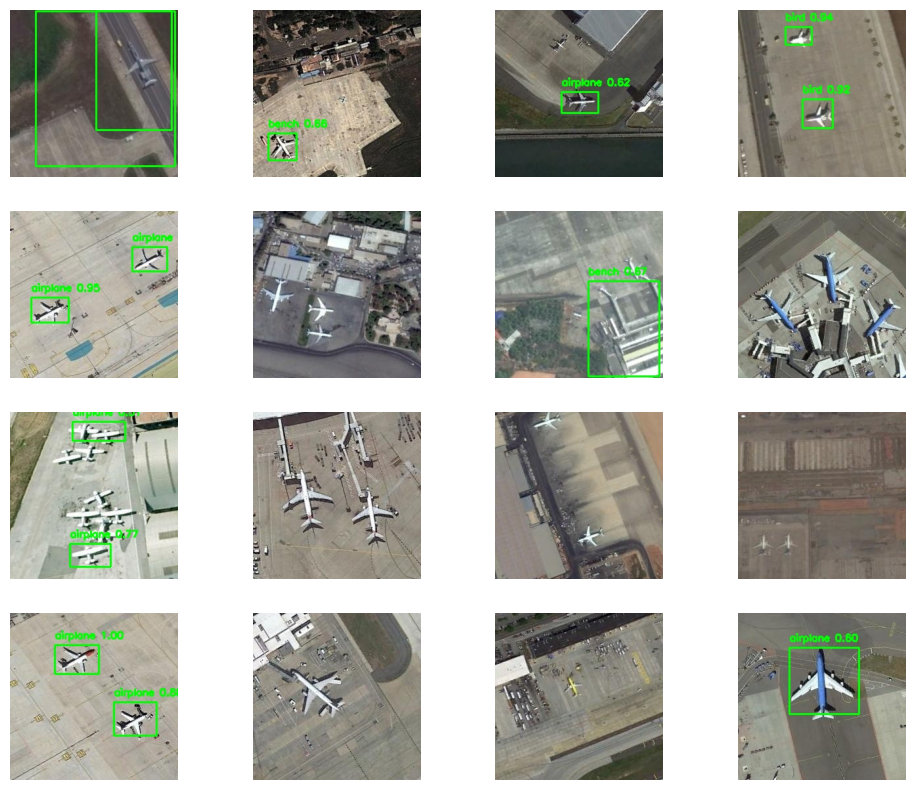

In [ ]:
# Display sameple

fig, axes = plt.subplots(4, 4)
for i in range(16):
    img_path = test_images[i]
    img = cv2.imread(output_path / img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i//4][i%4].imshow(img)
    axes[i//4][i%4].axis("off")
plt.show()

## 2. Mask RCNN

In [ ]:
import torch
from torch import nn
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights).to(device).eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 165MB/s]


In [ ]:
import os
from glob import glob
import random
import cv2

output_path = Path("./data/detections")
os.makedirs(output_path, exist_ok=True)

test_images = glob(os.path.join(images, "airplane_*.jpg"))
random.shuffle(test_images)
test_images = test_images[:25]

BOX_COLOR = (0, 255, 0)

classes = weights.meta["categories"]
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [ ]:
import numpy as np

for img_path in test_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        results = model(img_tensor)

    masks = results[0]["masks"].cpu().numpy()
    boxes = results[0]["boxes"].cpu().numpy()
    scores = results[0]["scores"].cpu().numpy()
    labels = results[0]["labels"].cpu().numpy()

    for mask, score, label, box in zip(masks, scores, labels, boxes):
        if score > 0.5:
            x1, y1, x2, y2 = map(int, box)
            mask = mask.squeeze(0)
            mask_color = (mask * 255).astype(np.uint8)
            mask_color = cv2.applyColorMap(mask_color, cv2.COLORMAP_RAINBOW)
            img = cv2.addWeighted(img, 0.7, mask_color, 0.3, 0)
            label_text = f"{classes[label]} {score:.2f}"
            cv2.putText(img, label_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, BOX_COLOR, 2)

    output_dir = output_path / img_path
    output_dir.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(output_dir, img)


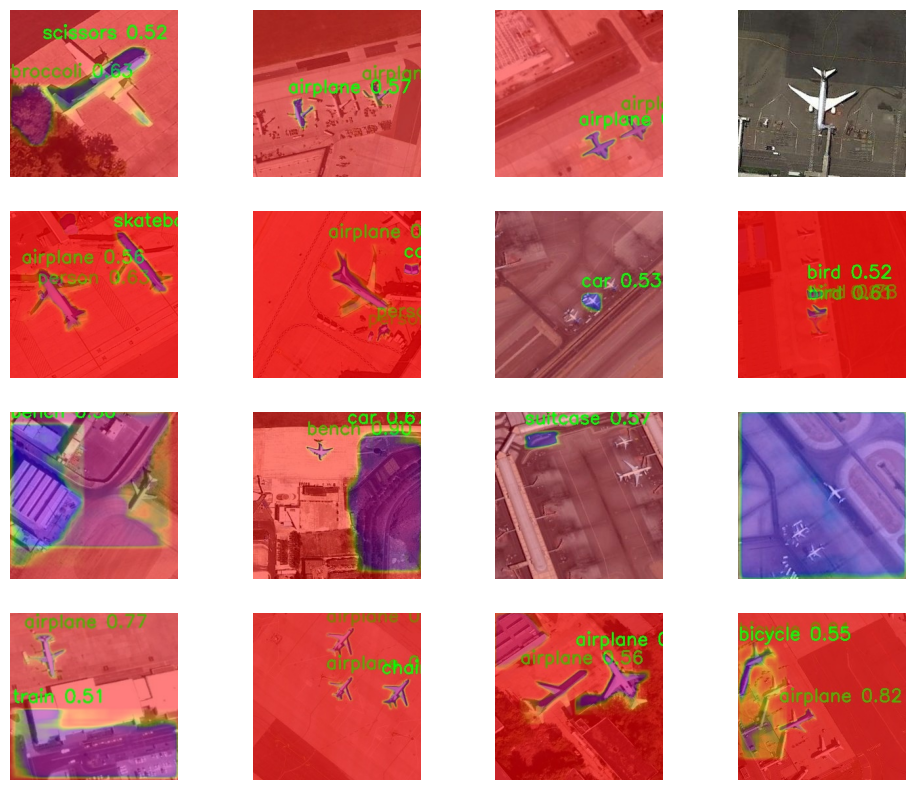

In [ ]:
# Display sameple

fig, axes = plt.subplots(4, 4)
for i in range(16):
    img_path = test_images[i]
    img = cv2.imread(output_path / img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i//4][i%4].imshow(img)
    axes[i//4][i%4].axis("off")
plt.show()